In [2]:
import sympy
import math
from sympy import integrate, Symbol, solve, dsolve, pprint, linsolve, solveset, simplify, expand, re, im, apart
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

def Plot_function(functions_list, func_name=""):
    #return 0
    x = sympy.Symbol("x")
    N = 300
    interval = [i/N-1/2 for i in range(N+1)]
    colors_and_width = [("y-", 2), ("b--", 2.5), ("g-.", 3), ("r:", 3.5)]
    number_of_plotted_functions = 0
    for i in range(len(functions_list)):
        f = functions_list[i]
        if f:
            if number_of_plotted_functions == 0:
                fig, ax = plt.subplots()
                ax.spines['left'].set_position('zero')
                ax.spines['left'].set_linewidth(1.5)
                ax.spines['bottom'].set_position('zero')
                ax.spines['bottom'].set_linewidth(1.5)
                ax.spines['right'].set_color('none')
                ax.spines['top'].set_color('none')
                ax.minorticks_on()
##                ax.xaxis.set_major_locator(MultipleLocator(1))
##                ax.yaxis.set_major_locator(MultipleLocator(40))
                ax.grid(which = 'minor', linewidth = 0.2)
                ax.grid(which = 'major', linewidth = 0.8)
                plt.title(str(func_name))
            number_of_plotted_functions += 1
            y = [re(f.subs(x, x_coord)) for x_coord in interval]
            plt.plot(interval, y, colors_and_width[i][0], linewidth = colors_and_width[i][1], markersize=0)
    if number_of_plotted_functions:
        plt.show(block = 0)
        
def poly_decomp(poly):
    import sympy as sp
    if poly.is_number:
        return poly
    x = sp.Symbol("x")
    apart_poly = sp.apart(poly, x)
    free_terms = 0
    if apart_poly.func == (x+1).func:
        for summand in apart_poly.args:
            if ((summand.is_number) or
               (summand.func == x.func) or
               (summand.func == (x*2).func and len(summand.args) == 2 and (summand.args[0].func == x.func or summand.args[1].func == x.func)) or
               (len(summand.args) == 2 and summand.args[0].func == (x**2).func and summand.args[0].args[1] >= 0) or 
               (len(summand.args) == 2 and summand.args[1].func == (x**2).func and summand.args[1].args[1] >= 0) or
               (summand.func == (x**2).func and summand.args[1] > -1) or
               (summand.func == (x*2).func and len(summand.args) == 2 and (summand.args[0] == 1/x or summand.args[1] == 1/x))):
                free_terms += summand
    if apart_poly.func == x.func or (apart_poly.func == (x**2).func and apart_poly.args[1] > -1) or (apart_poly.func == (x*2).func and (apart_poly.args[0].func == x.func or apart_poly.args[1].func == x.func)): 
        free_terms = apart_poly
    apart_poly = sp.simplify(apart_poly - free_terms)
    if apart_poly == 0:
        return free_terms
    numerator = 1
    denominator = 1
    if apart_poly.func == (x**2).func:
        denominator = apart_poly.args[0]
    else:
        for multiplier in apart_poly.args:
            if multiplier.func == (x**2).func and multiplier.args[1] == -1:
                denominator *= multiplier.args[0]
            else:
                numerator *= multiplier
    roots_list = sp.nroots(denominator, 20)
    for i in range(len(roots_list)):
        if abs(roots_list[i]) <= 1e-5 or abs(im(roots_list[i])/re(roots_list[i])) <= 0.001:
            roots_list[i] = re(roots_list[i])
    roots_list_used = []
    roots_dict = dict()
    for r in roots_list:
        new_root = 1
        for i in roots_list_used:
            if (i == 0 and r == 0) or abs((i-r)/i) <= 0.01:
                roots_dict[i] += 1
                new_root = 0
                break
        if new_root == 1:
            roots_dict[r] = 1
            roots_list_used.append(r)
    sp.LC(denominator)
    new_denominator = sp.LC(denominator)
    for i in roots_list_used:
        new_denominator = sp.Mul(new_denominator, sp.Pow((x-i), roots_dict[i], evaluate = False), evaluate = False)
    rhs = 0
    variables = sp.symbols("A:20")
    root_number = 0
    var_number = 0
    deg_number = 1
    RESULT = 0
    while 1:
        RESULT += variables[var_number] * (x-roots_list_used[root_number])**(-deg_number) 
        rhs += sp.cancel(variables[var_number] * (x-roots_list_used[root_number])**(-deg_number) * new_denominator)
        deg_number += 1
        if deg_number > roots_dict[roots_list_used[root_number]]:
            root_number += 1
            deg_number = 1
        var_number += 1
        if root_number == len(roots_list_used):
            break
    rhs_poly = sp.poly_from_expr(rhs, x)[0]
    numerator_poly = sp.poly_from_expr(numerator, x)[0]
    SLAE = []
    for i in range(var_number):
        eq = sp.Eq(rhs_poly.coeff_monomial(x**i), numerator_poly.coeff_monomial(x**i))
        SLAE.append(eq)
    solution = sp.solve(SLAE)
    for i in range(var_number):
        if abs(solution[variables[i]]) < 1e-6:
            solution[variables[i]] = 0
        rhs = rhs.subs(variables[i], solution[variables[i]])
        RESULT = RESULT.subs(variables[i], solution[variables[i]])
    return RESULT + free_terms

def poly_log_decomp(poly_log):
    import sympy as sp
    import math
    from sympy import I, log, pi, expand
    x = sp.Symbol("x")
    numerator = 1
    if expr.func == (x**2).func:
        denominator = expr.args[0]
    else:
        for multiplier in expr.args:
            if multiplier.func == (x**2).func and multiplier.args[1] == -1:
                denominator = multiplier.args[0]
            else:
                numerator *= multiplier
    numerator = expand(numerator)
    log_part = dict()
    common_part = 0
    for summand in numerator.args:
        if summand.func != (x*2).func:
            if summand.func != (sympy.log).func:
                common_part += summand
            else:
                log_part[summand] += 1
        else:
            current_mult = 1
            log_in_summand = 0
            for multiplier_in_summand in summand.args:
                if multiplier_in_summand.func == (sympy.log):
                    log_in_summand = multiplier_in_summand
                    if log_part.get(log_in_summand, 0) == 0:
                        log_part[log_in_summand] = []
                else:
                    current_mult *= multiplier_in_summand
            if log_in_summand == 0:
                common_part += current_mult
            else:
                log_part[log_in_summand].append(current_mult)
    com_part_decomp = poly_decomp((common_part/denominator).replace(sp.pi, math.pi))
    RESULT_SUM_list = []
    if com_part_decomp.func == (x+1).func:
        for i in com_part_decomp.args:
            RESULT_SUM_list.append(i)
    else:
        RESULT_SUM_list.append(com_part_decomp)
    for key in log_part.keys():
        for summand in log_part[key]:
            summand_decomp = poly_decomp((summand/denominator).replace(sp.pi, math.pi))
            if summand_decomp.func != (x+1).func:
                RESULT_SUM_list.append(summand_decomp*key)
            else:
                for summ_in_summ in summand_decomp.args:
                    RESULT_SUM_list.append(summ_in_summ*key)
    RESULT_SUM_list = tuple(RESULT_SUM_list)
    RESULT_SUM = sp.Add(*RESULT_SUM_list, evaluate=False)
    return RESULT_SUM

def get_C_ijkl(E11 = 430, E22 = 6.9, v12 = 0.3, v23 = 0.49, G12 = 2.65, G23 = 2.32):  
    v21 = v12/E11*E22
    v32 = v23
    J_IJ = sympy.Matrix([[1/E11, -v21/E22, -v21/E22, 0, 0, 0],
                         [-v12/E11, 1/E22, -v32/E22, 0, 0, 0],
                         [-v12/E11, -v23/E22, 1/E22, 0, 0, 0],
                         [0, 0, 0, 1/G12, 0 ,0],
                         [0, 0, 0, 0, 1/G23, 0],
                         [0, 0, 0, 0, 0, 1/G12]])
    C_IJ = J_IJ**-1
##    print(f"{C_IJ = }")
##    print(f"{J_IJ = }")
    C_ijkl = [[[[None, None, None] for k in range(3)] for j in range(3)] for i in range(3)]
    C_ijkl[1-1][1-1][1-1][1-1] = C_IJ[1-1,1-1]
    C_ijkl[1-1][1-1][2-1][2-1] = C_IJ[1-1,2-1]
    C_ijkl[1-1][1-1][3-1][3-1] = C_IJ[1-1,3-1]
    C_ijkl[1-1][1-1][2-1][3-1] = C_IJ[1-1,4-1]
    C_ijkl[1-1][1-1][1-1][3-1] = C_IJ[1-1,5-1]
    C_ijkl[1-1][1-1][1-1][2-1] = C_IJ[1-1,6-1]

    C_ijkl[2-1][2-1][1-1][1-1] = C_IJ[2-1,1-1]
    C_ijkl[2-1][2-1][2-1][2-1] = C_IJ[2-1,2-1]
    C_ijkl[2-1][2-1][3-1][3-1] = C_IJ[2-1,3-1]
    C_ijkl[2-1][2-1][2-1][3-1] = C_IJ[2-1,4-1]
    C_ijkl[2-1][2-1][1-1][3-1] = C_IJ[2-1,5-1]
    C_ijkl[2-1][2-1][1-1][2-1] = C_IJ[2-1,6-1]

    C_ijkl[3-1][3-1][1-1][1-1] = C_IJ[3-1,1-1]
    C_ijkl[3-1][3-1][2-1][2-1] = C_IJ[3-1,2-1]
    C_ijkl[3-1][3-1][3-1][3-1] = C_IJ[3-1,3-1]
    C_ijkl[3-1][3-1][2-1][3-1] = C_IJ[3-1,4-1]
    C_ijkl[3-1][3-1][1-1][3-1] = C_IJ[3-1,5-1]
    C_ijkl[3-1][3-1][1-1][2-1] = C_IJ[3-1,6-1]

    C_ijkl[2-1][3-1][1-1][1-1] = C_IJ[4-1,1-1]
    C_ijkl[2-1][3-1][2-1][2-1] = C_IJ[4-1,2-1]
    C_ijkl[2-1][3-1][3-1][3-1] = C_IJ[4-1,3-1]
    C_ijkl[2-1][3-1][2-1][3-1] = C_IJ[4-1,4-1]
    C_ijkl[2-1][3-1][1-1][3-1] = C_IJ[4-1,5-1]
    C_ijkl[2-1][3-1][1-1][2-1] = C_IJ[4-1,6-1]

    C_ijkl[3-1][1-1][1-1][1-1] = C_IJ[5-1,1-1]
    C_ijkl[3-1][1-1][2-1][2-1] = C_IJ[5-1,2-1]
    C_ijkl[3-1][1-1][3-1][3-1] = C_IJ[5-1,3-1]
    C_ijkl[3-1][1-1][2-1][3-1] = C_IJ[5-1,4-1]
    C_ijkl[3-1][1-1][1-1][3-1] = C_IJ[5-1,5-1]
    C_ijkl[3-1][1-1][1-1][2-1] = C_IJ[5-1,6-1]

    C_ijkl[1-1][2-1][1-1][1-1] = C_IJ[6-1,1-1]
    C_ijkl[1-1][2-1][2-1][2-1] = C_IJ[6-1,2-1]
    C_ijkl[1-1][2-1][3-1][3-1] = C_IJ[6-1,3-1]
    C_ijkl[1-1][2-1][2-1][3-1] = C_IJ[6-1,4-1]
    C_ijkl[1-1][2-1][1-1][3-1] = C_IJ[6-1,5-1]
    C_ijkl[1-1][2-1][1-1][2-1] = C_IJ[6-1,6-1]
    for i in range(3):
        for j in range(3):
            if i == j or (i,j) in ((1,2),(2,0),(0,1)):
                div_by_2 = 1
                C_ijkl[i][j][1][2] /= div_by_2
                C_ijkl[i][j][0][1] /= div_by_2
                C_ijkl[i][j][0][2] /= div_by_2
    for three_times in range(3):
        for i in range(3):
            for j in range(3):
                for k in range(3):
                    for l in range(3):
                        first_num = None
                        eq_mass = [C_ijkl[i][j][k][l], C_ijkl[j][i][k][l], C_ijkl[i][j][l][k], C_ijkl[k][l][i][j]]
                        for el in eq_mass:
                            if first_num == None:
                                first_num = el
                        for el in eq_mass:
                            if not (el == None) and not abs(el-first_num)<1e-7:
                                print(f"EXIT; ijkl = {i} {j} {k} {l}     ", eq_mass)
                                exit()
                        for el_num in range(len(eq_mass)):
                            C_ijkl[i][j][k][l] = first_num
                            C_ijkl[j][i][k][l] = first_num
                            C_ijkl[i][j][l][k] = first_num
                            C_ijkl[k][l][i][j] = first_num
#    print(f"{C_ijkl = }")
    return C_ijkl

def get_C_ijkl_FGM():
    E_nic = 200 #GPa
    Nu_nic = 0.31
    Lambda_nic = Nu_nic*E_nic/(1+Nu_nic)/(1-2*Nu_nic)
    Mu_nic = E_nic/2/(1+Nu_nic)
    K_nic = Lambda_nic+2/3*Nu_nic
    E_cer = 380
    Nu_cer = 0.25
    Lambda_cer = Nu_cer*E_cer/(1+Nu_cer)/(1-2*Nu_cer)
    Mu_cer = E_cer/2/(1+Nu_cer)
    K_cer = Lambda_cer+2/3*Nu_cer
    
    #Mu_nic, Mu_cer, Lambda_nic, Lambda_cer = sympy.symbols("M1 M2 L1 L2")
    #Mu_nic, Mu_cer, Lambda_nic, Lambda_cer = (1,2,3,4)
    G = sympy.Symbol("G")
    Mu_eff = Mu_nic*Mu_cer/((1-G)*Mu_nic+G*Mu_cer)
    Lambda_eff = (Mu_nic*Lambda_cer*(3*Lambda_nic+2*Mu_nic)*(1-G)+G*Lambda_nic*Mu_cer*(3*Lambda_cer+2*Mu_cer)) / (((1-G)*(3*Lambda_nic+2*Mu_nic)+G*(3*Lambda_cer+2*Mu_cer))*((1-G)*Mu_nic+G*Mu_cer))    
    #Mu_eff = G*Mu_nic+(G-1)*Mu_cer
    #Lambda_eff = G*Lambda_nic+(G-1)*Lambda_cer
    
    x = sympy.Symbol("x")
    dependance_G_x = 1-(x*2)**2
    Lambda_eff = Lambda_eff.subs(G, dependance_G_x)
    Mu_eff = Mu_eff.subs(G, dependance_G_x)
    #Plot_function([Lambda_eff], "Lambda_eff")
    #Plot_function([Mu_eff], "Mu_eff")
    #print(f"{Lambda_eff = }; {Mu_eff = }")
    C_ijkl = [[[[None, None, None] for k in range(3)] for j in range(3)] for i in range(3)]
    for i in range(3):
        for j in range(3):
            for k in range(3):
                for l in range(3):
                    d_ij = 1 if i == j else 0
                    d_kl = 1 if k == l else 0
                    d_ik = 1 if i == k else 0
                    d_jl = 1 if j == l else 0
                    d_il = 1 if i == l else 0
                    d_jk = 1 if j == k else 0
                    C_ijkl[i][j][k][l] = Lambda_eff*d_ij*d_kl + Mu_eff*(d_ik*d_jl+d_il*d_jk)
    #print(C_ijkl)
    return C_ijkl

def get_C_ijkl_symbolic():
    C_ijkl = [[[[0, 0, 0] for k in range(3)] for j in range(3)] for i in range(3)]
    C_1111, C_1122, C_1133, C_2222, C_2233, C_3333, C_1212, C_1313, C_2323 = sympy.symbols("C_1111 C_1122 C_1133 C_2222 C_2233 C_3333 C_1212 C_1313 C_2323")
    C_ijkl[0][0][0][0] = C_1111
    C_ijkl[0][0][1][1] = C_1122
    C_ijkl[1][1][0][0] = C_1122
    C_ijkl[0][0][2][2] = C_1133
    C_ijkl[2][2][0][0] = C_1133
    C_ijkl[1][1][1][1] = C_2222
    C_ijkl[1][1][2][2] = C_2233
    C_ijkl[2][2][1][1] = C_2233
    C_ijkl[2][2][2][2] = C_3333
    
    C_ijkl[2][1][1][2] = C_2323
    C_ijkl[1][2][1][2] = C_2323
    C_ijkl[2][1][2][1] = C_2323
    C_ijkl[1][2][2][1] = C_2323
    
    C_ijkl[0][1][0][1] = C_1212
    C_ijkl[0][1][1][0] = C_1212
    C_ijkl[1][0][1][0] = C_1212
    C_ijkl[1][0][0][1] = C_1212
    
    C_ijkl[0][2][2][0] = C_1313
    C_ijkl[0][2][0][2] = C_1313
    C_ijkl[2][0][2][0] = C_1313
    C_ijkl[2][0][0][2] = C_1313
    return C_ijkl

def get_1_approx_nonhomog(C_and_N_functions):
    C_ijkl = C_and_N_functions[0]
    x = sympy.Symbol("x")
    C1 = Symbol("C1")
    N_kpq0 = [[[None, None, None] for j in range(3)] for i in range(3)]
    P_ijpq0 = [[[[None, None, None] for k in range(3)] for j in range(3)] for i in range(3)]
    for i in range(3):
        for p in range(2):
            for q0 in range(2):
                eq_for_1_integration = C_ijkl[i][2][p][q0]*x/C_ijkl[i][2][i][2]
                eq_for_1_integration = eq_for_1_integration.simplify()
                eq_for_1_integration = eq_for_1_integration.expand()
                #print(f"{eq_for_1_integration = }")
                one_param_solution = eq_for_1_integration.integrate(x)
                #print(f"{one_param_solution = }")
                c1_number = -integrate(one_param_solution, (x, -1/2, 1/2))
                #print(f"{c1_number = }")
                final_solution = one_param_solution + c1_number
                N_kpq0[i][p][q0] = final_solution
                #N_kpq0[i][p][q0] = -x if (i == 2 and p == q0) else x-x
                print(f"N_{i+1}{p+1}{q0+1} = {N_kpq0[i][p][q0]}")
                Plot_function([N_kpq0[i][p][q0]], f"N_{i+1}{p+1}{q0+1}")
    
    for i in range(3):
        for j in range(3):
            for p in range(2):
                for q0 in range(2):
                    P_ijpq0[i][j][p][q0] = C_ijkl[i][j][p][q0] + C_ijkl[i][j][0][2]*N_kpq0[0][p][q0].diff(x) +\
                                            + C_ijkl[i][j][1][2]*N_kpq0[1][p][q0].diff(x) + C_ijkl[i][j][2][2]*N_kpq0[2][p][q0].diff(x)
                    #print(f"P_{i+1}{j+1}{p+1}{q0+1} = {P_ijpq0[i][j][p][q0]}")
    return N_kpq0, P_ijpq0

C_ijkl = get_C_ijkl_FGM()
C_ijkl = get_C_ijkl()
#C_ijkl = get_C_ijkl_symbolic()
C_and_N_functions = [C_ijkl]
P_functions = [None]




In [3]:
#import sympy as sp
#x = sp.Symbol("x")
#e_dec = poly_decomp(expr)
#print(e_dec)

N_111 = 0
N_112 = 0
N_121 = 0
N_122 = 0
N_211 = 0
N_212 = 0
N_221 = 0
N_222 = 0
N_311 = 0.223823242403564*x**2 - 0.0186519368669637


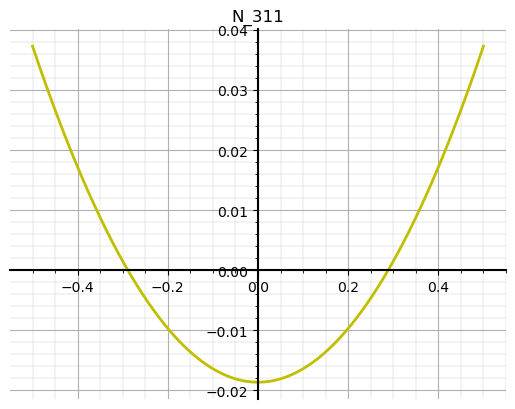

N_312 = 0
N_321 = 0
N_322 = 0.246077474678547*x**2 - 0.0205064562232123


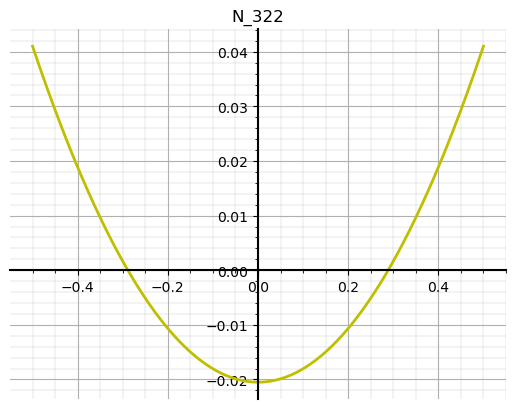

In [4]:
N1, P1 = get_1_approx_nonhomog(C_and_N_functions)
C_and_N_functions.append(N1)
P_functions.append(P1)

eq_for_2_integrations = 185.165240643043*x
N_1111 = 30.8608734405071*x**3 - 23.1829589541143*x


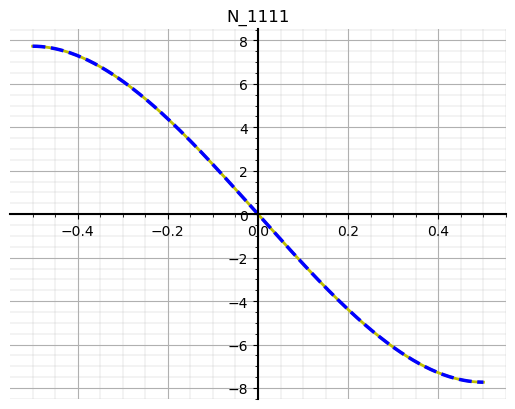

eq_for_2_integrations = 0
N_1112 = 0
eq_for_2_integrations = 0
N_1121 = 0
eq_for_2_integrations = 1.14224137931034*x
N_1122 = 0.190373563218391*x**3 - 0.142780172413793*x


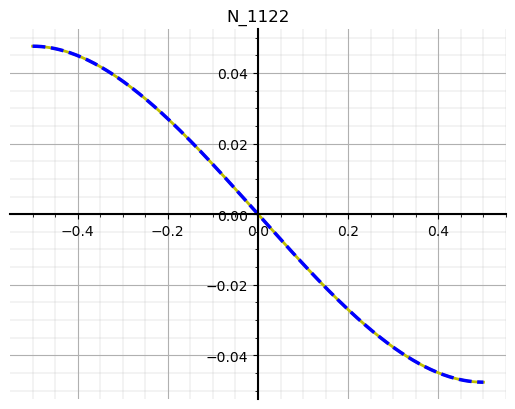

eq_for_2_integrations = 0
N_1211 = 0
eq_for_2_integrations = 1.14224137931034*x
N_1212 = 0.190373563218391*x**3 - 0.142780172413793*x


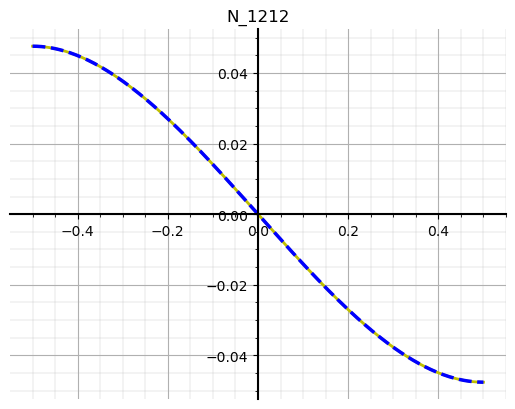

eq_for_2_integrations = 0.401376856118833*x
N_1221 = 0.0668961426864721*x**3 - 0.0911850194612785*x


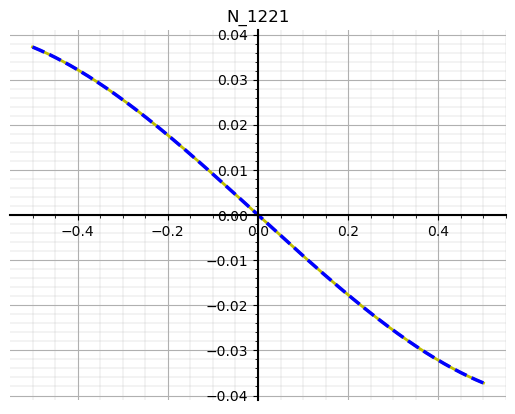

eq_for_2_integrations = 0
N_1222 = 0
eq_for_2_integrations = 0
N_2111 = 0
eq_for_2_integrations = 0.334615322251042*x
N_2112 = 0.0557692203751737*x**3 - 0.0791307890153076*x


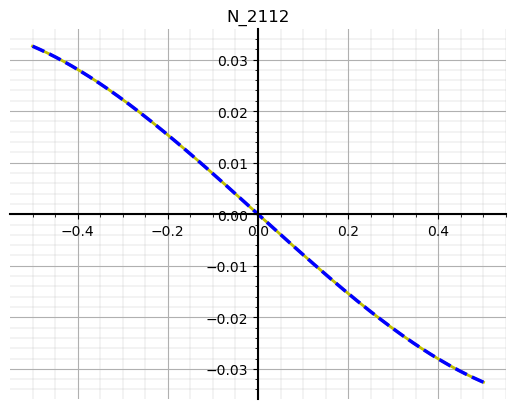

eq_for_2_integrations = 1.0*x
N_2121 = 0.166666666666667*x**3 - 0.125*x


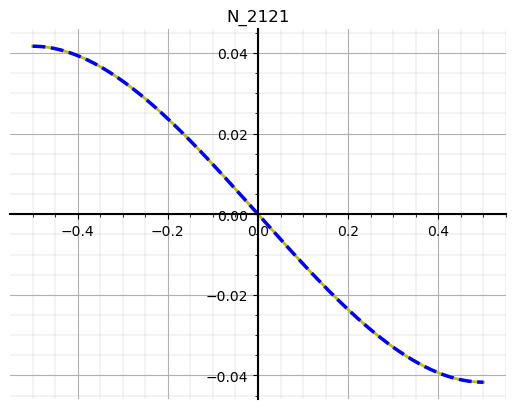

eq_for_2_integrations = 0
N_2122 = 0
eq_for_2_integrations = 1.0*x
N_2211 = 0.166666666666667*x**3 - 0.125*x


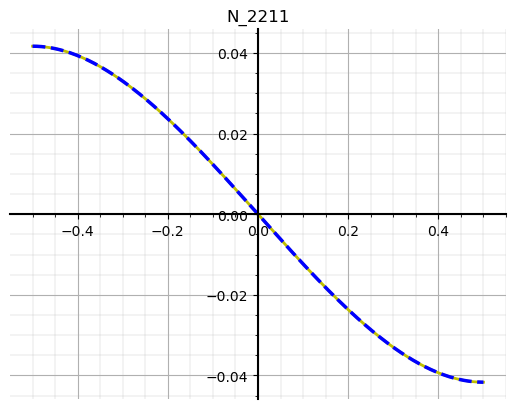

eq_for_2_integrations = 0
N_2212 = 0
eq_for_2_integrations = 0
N_2221 = 0
eq_for_2_integrations = 2.11538440750347*x
N_2222 = 0.352564067917246*x**3 - 0.305435963384359*x


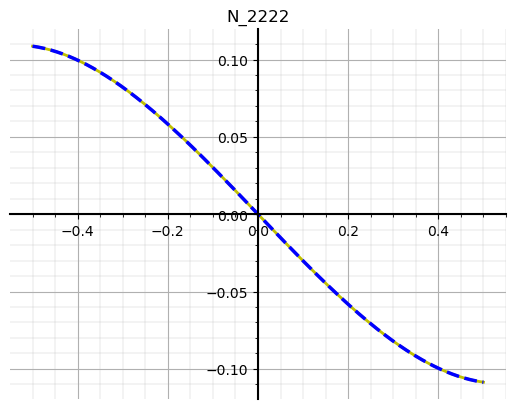

eq_for_2_integrations = 0
N_3111 = 0
eq_for_2_integrations = 0
N_3112 = 0
eq_for_2_integrations = 0
N_3121 = 0
eq_for_2_integrations = 0
N_3122 = 0
eq_for_2_integrations = 0
N_3211 = 0
eq_for_2_integrations = 0
N_3212 = 0
eq_for_2_integrations = 0
N_3221 = 0
eq_for_2_integrations = 0
N_3222 = 0


In [5]:
def get_2_approx_nonhomog(C_and_N_functions, P_functions):
    C_ijkl = C_and_N_functions[0]
    N_kpq0 = C_and_N_functions[1]
    x = sympy.Symbol("x")
    C1 = Symbol("C1")
    C2 = Symbol("C2")
    undef_func = sympy.Function("undef_func")
    N_kpq0q1 = [[[[None, None, None] for k in range(3)] for j in range(3)] for i in range(3)]
    for i in range(3):
        for p in range(2):      
            for q0 in range(2):
                for q1 in range(2):
                    eq_for_2_integrations = -C_ijkl[i][q1][p][q0]*x +\
                                          + (C_ijkl[i][q1][0][2] + C_ijkl[i][2][0][q1])*N_kpq0[0][p][q0].diff(x) +\
                                          + (C_ijkl[i][q1][1][2] + C_ijkl[i][2][1][q1])*N_kpq0[1][p][q0].diff(x) +\
                                          + (C_ijkl[i][q1][2][2] + C_ijkl[i][2][2][q1])*N_kpq0[2][p][q0].diff(x)
                    eq_for_2_integrations /= -C_ijkl[i][2][i][2]
                    eq_for_2_integrations = eq_for_2_integrations.simplify()
                    print(f"{eq_for_2_integrations = }")
                    if eq_for_2_integrations.func == (x*3).func and 0:
                        eq_for_2_integrations = poly_decomp(eq_for_2_integrations)
                        one_param_solution = 0
                        if eq_for_2_integrations.func == (x+3).func:
                            for summand in eq_for_2_integrations.args:
                                one_param_solution += sympy.integrate(summand, x)
                        else:
                            one_param_solution += sympy.integrate(eq_for_2_integrations, x)
                        two_param_solution = 0
                        for summand in one_param_solution.args:
                            two_param_solution += sympy.integrate(summand, x)
                        c1 = 0
                        for summand in two_param_solution.args:
                            c1 -= sympy.integrate(summand, (x, -1/2, 1/2))
                    else:
                        one_param_solution = sympy.integrate(eq_for_2_integrations, x) 
                        two_param_solution = sympy.integrate(one_param_solution, x)
                        c1 = -integrate(two_param_solution, (x, -1/2, 1/2))
                    bound_cond = C_ijkl[i][2][0][q1]*N_kpq0[0][p][q0] +\
                               + C_ijkl[i][2][1][q1]*N_kpq0[1][p][q0] +\
                               + C_ijkl[i][2][2][q1]*N_kpq0[2][p][q0] +\
                               + C_ijkl[i][2][i][2]*(one_param_solution+C2)
                    bound_cond = sympy.Eq(bound_cond.subs(x, -1/2), 0)
                    c2 = solve(bound_cond, C2)[0]
                    
                    bound_cond1 = C_ijkl[i][2][0][q1]*N_kpq0[0][p][q0] +\
                               + C_ijkl[i][2][1][q1]*N_kpq0[1][p][q0] +\
                               + C_ijkl[i][2][2][q1]*N_kpq0[2][p][q0] +\
                               + C_ijkl[i][2][i][2]*(one_param_solution+C2)
                    bound_cond1 = sympy.Eq(bound_cond1.subs(x, 1/2), 0)
                    c2_1 = solve(bound_cond1, C2)[0]
                    final_solution = two_param_solution + c2*x + c1
                    final_solution1 = two_param_solution + c2_1*x + c1
                    N_kpq0q1[i][p][q0][q1] = final_solution
                    print(f"N_{i+1}{p+1}{q0+1}{q1+1} = {N_kpq0q1[i][p][q0][q1]}")
                    Plot_function([N_kpq0q1[i][p][q0][q1], final_solution1], f"N_{i+1}{p+1}{q0+1}{q1+1}")
    return N_kpq0q1
N2 = get_2_approx_nonhomog(C_and_N_functions, P_functions)
C_and_N_functions.append(N2)

In [6]:
def get_3_approx_nonhomog(C_and_N_functions, P_functions):
    C_ijkl = C_and_N_functions[0]
    N_kpq0 = C_and_N_functions[1]
    N_kpq0q1 = C_and_N_functions[2]
    for i in range(3):
        for p in range(2):      
            for q0 in range(2):
                for q1 in range(2):
                    print(f"N_{i+1}{p+1}{q0+1}{q1+1} = {N_kpq0q1[i][p][q0][q1]}")
    x = sympy.Symbol("x")
    C1 = Symbol("C1")
    C2 = Symbol("C2")
    undef_func = sympy.Function("undef_func")
    N_kpq0q1q2 = [[[[[None, None, None] for l in range(3)] for k in range(3)] for j in range(3)] for i in range(3)]
    for i in range(3):
        for p in range(2):      
            for q0 in range(2):
                for q1 in range(2):
                    for q2 in range(2):
                        eq_for_2_integrations = C_ijkl[i][q2][0][q1]*N_kpq0[0][p][q0] +\
                                              + C_ijkl[i][q2][1][q1]*N_kpq0[1][p][q0] +\
                                              + C_ijkl[i][q2][2][q1]*N_kpq0[2][p][q0] +\
                                              + (C_ijkl[i][q2][0][2] + C_ijkl[i][2][0][q2])*N_kpq0q1[0][p][q0][q1].diff(x) +\
                                              + (C_ijkl[i][q2][1][2] + C_ijkl[i][2][1][q2])*N_kpq0q1[1][p][q0][q1].diff(x) +\
                                              + (C_ijkl[i][q2][2][2] + C_ijkl[i][2][2][q2])*N_kpq0q1[2][p][q0][q1].diff(x)
                        eq_for_2_integrations /= -C_ijkl[i][2][i][2]
                        eq_for_2_integrations = eq_for_2_integrations.simplify()
                        #print(f"{C_ijkl[i][q2][1][q1] = }; {N_kpq0[0][p][q0] = }; {N_kpq0q1[2][p][q0][q1].diff(x) = }")
                        print(f"{eq_for_2_integrations = }")
                        if eq_for_2_integrations.func == (x*3).func and 0:
                            eq_for_2_integrations = poly_log_decomp(eq_for_2_integrations)
                            one_param_solution = 0
                            for summand in eq_for_2_integrations.args:
                                #print(f"{summand = }")
                                one_param_solution += sympy.integrate(summand, x)
                            #print(f"{one_param_solution = }")
                            two_param_solution = 0
                            for summand in one_param_solution.args:
                                two_param_solution += sympy.integrate(summand, x)
                            #print(f"{two_param_solution = }")
                            c1 = 0
                            for summand in two_param_solution.args:
                                c1 -= sympy.integrate(summand, (x, -1/2, 1/2))
                        else:
                            one_param_solution = sympy.integrate(eq_for_2_integrations, x) 
                            two_param_solution = sympy.integrate(one_param_solution, x)
                            c1 = -integrate(two_param_solution, (x, -1/2, 1/2))
                        print(f"{one_param_solution = }")
                        print(f"{two_param_solution = }")
                        bound_cond = C_ijkl[i][2][0][q2]*N_kpq0q1[0][p][q0][q1] +\
                                    + C_ijkl[i][2][1][q2]*N_kpq0q1[1][p][q0][q1] +\
                                    + C_ijkl[i][2][2][q2]*N_kpq0q1[2][p][q0][q1] +\
                                    + C_ijkl[i][2][i][2]*(one_param_solution+C2)
                        print(f"{bound_cond = }")
                        bound_cond = sympy.Eq(bound_cond.subs(x, -1/2), 0)
                        c2 = solve(bound_cond, C2)[0]

                        bound_cond1 = C_ijkl[i][2][0][q2]*N_kpq0q1[0][p][q0][q1] +\
                                    + C_ijkl[i][2][1][q2]*N_kpq0q1[1][p][q0][q1] +\
                                    + C_ijkl[i][2][2][q2]*N_kpq0q1[2][p][q0][q1] +\
                                    + C_ijkl[i][2][i][2]*(one_param_solution+C2)
                        #print(f"sum = {C_ijkl[i][2][0][q1]*N_kpq0[0][p][q0] + C_ijkl[i][2][1][q1]*N_kpq0[1][p][q0] + C_ijkl[i][2][2][q1]*N_kpq0[2][p][q0]}")
                        bound_cond1 = sympy.Eq(bound_cond1.subs(x, 1/2), 0)
                        c2_1 = solve(bound_cond1, C2)[0]
                        print(f"{c2 = }; {c2_1 = }\n")
                        final_solution = two_param_solution + c2*x + c1
                        final_solution1 = two_param_solution + c2_1*x + c1
                        N_kpq0q1q2[i][p][q0][q1][q2] = final_solution
                        Plot_function([N_kpq0q1q2[i][p][q0][q1][q2]], f"N_{i+1}{p+1}{q0+1}{q1+1}{q2+1}")
    return N_kpq0q1
N3 = get_3_approx_nonhomog(C_and_N_functions, P_functions)
C_and_N_functions.append(N3)

N_1111 = 30.8608734405071*x**3 - 23.1829589541143*x
N_1112 = 0
N_1121 = 0
N_1122 = 0.190373563218391*x**3 - 0.142780172413793*x
N_1211 = 0
N_1212 = 0.190373563218391*x**3 - 0.142780172413793*x
N_1221 = 0.0668961426864721*x**3 - 0.0911850194612785*x
N_1222 = 0
N_2111 = 0
N_2112 = 0.0557692203751737*x**3 - 0.0791307890153076*x
N_2121 = 0.166666666666667*x**3 - 0.125*x
N_2122 = 0
N_2211 = 0.166666666666667*x**3 - 0.125*x
N_2212 = 0
N_2221 = 0
N_2222 = 0.352564067917246*x**3 - 0.305435963384359*x
N_3111 = 0
N_3112 = 0
N_3121 = 0
N_3122 = 0
N_3211 = 0
N_3212 = 0
N_3221 = 0
N_3222 = 0
eq_for_2_integrations = 0
one_param_solution = 0
two_param_solution = 0
bound_cond = 2.32*C2


NameError: name 'D_ijpq0' is not defined